# Xarray-spatial User Guide:
### Proximity (Distance) tools
-----
The Proximity tools let you calculate the distance between points in three distance metrics: Euclidean (straight-line), Manhattan (with path obstacles, i.e., taxicab distance), and Great Cricle (distance on the surface of a sphere). 

[Proximity Distance](#Proximity-Distance): Calculates the distance to the nearest of a set of target - or source - points for each point in the input raster.

[Proximity Allocation](#Proximity-Allocation): Identifies the nearest source (target) point (the 'allocation' point) for each cell in the input raster.

[Proximity Direction](#Proximity-Direction): Returns the direction to the nearest source (target) point (the 'allocation') for each cell in the input raster.

-----------


#### Let's use datashader to render our images...

In [379]:
import numpy as np
import datashader as ds
from datashader.transfer_functions import shade
from datashader.transfer_functions import stack
from datashader.transfer_functions import dynspread
from datashader.transfer_functions import set_background
from datashader.colors import Elevation

import xrspatial

## Proximity Distance

Xrspatial's proximity function operates on an aggregate raster with target features or values to calculate the distance at each point in the raster from the nearest one of the target points. It returns the distance values at each point as a new xarray DataArray aggregate.

A powerful feature of `proximity` is that you can target a specific set of values to measure distances from, through the `target_values` parameter. If this isn't set explicitly, then it default to all non-zero value points. 

Let's set up a raster and see what applying proximity shows us.

#### Setup:

First, we'll import proximity.

Next, we'll set up the datashader Canvas object,  
set up the sample data in a DataFrame, and finally, aggregate  
aggregate it by inputting it into the canvas points method.

This all sets us up with an input raster we can use in the proximity function.

In [491]:
from xrspatial import proximity

import pandas as pd

W = 800
H = 600

cvs = ds.Canvas(plot_width=W, plot_height=H,
                x_range=(-20, 20), y_range=(-20, 20))

df = pd.DataFrame({
   'x': [-13, -11, -5, 4, 9, 11, 18, 6],
   'y': [-13, -5, 0, 10, 7, 2, 5, -5],
   'id': [1, 2, 3, 4, 5, 6, 7, 8],
})

points_agg = cvs.points(df, x='x', y='y', agg=ds.sum('id'))
# points_agg = points_agg.astype(int)
type(points_agg), points_agg.data

(xarray.core.dataarray.DataArray,
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]))

As you can see, there's a lot of nan values where there are no target values.  
We'll just go ahead and fix that quickly by setting those to zero,  
and then we'll just do a quick shading and visualizion.

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


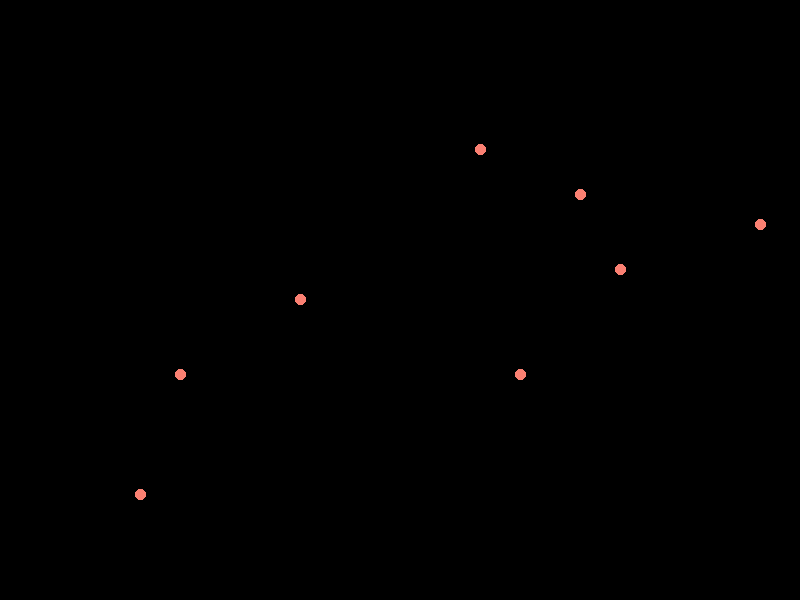

In [492]:
#data cleanup
points_agg.data[~np.isfinite(points_agg.data)] = 0
# visualization
points_shaded = dynspread(shade(points_agg, cmap='salmon', how='linear', min_alpha=0, span=(0,1)),
                            threshold=1,
                             max_px=5)
set_background(points_shaded, 'black')

   #### Apply Proximity:
   Now we can apply the proximity function to our points aggregate.

##### Set Targets:
We can set the target_values parameter to a subset of the points, for example, 1, 2, 3, and 4, to only measure distance everywhere from the nearest of these four points.
Finally, we can shade the resulting distance raster and stack it with the points raster.

Note: feel free to remove or add to the targets from among the digits 1-8 and see how the image changes.

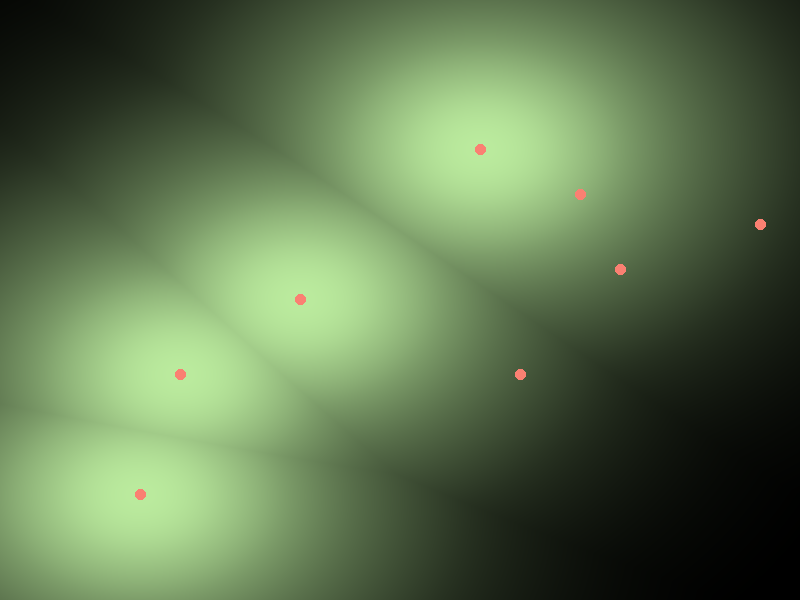

In [498]:
targets = [1, 2, 3, 4]
target_proximity_agg = proximity(points_agg, target_values=targets, distance_metric="GREAT_CIRCLE")

stack(shade(target_proximity_agg, cmap=['#bbeb9e', 'black'], how='eq_hist'),
      points_shaded)

Note the brighter areas nearer the target points and the black lines along areas that are equal distance to two points. 

##### Default Targets: All Non-zero Points
Leaving out the target_values parameter entirely defaults it to all non-zero points.

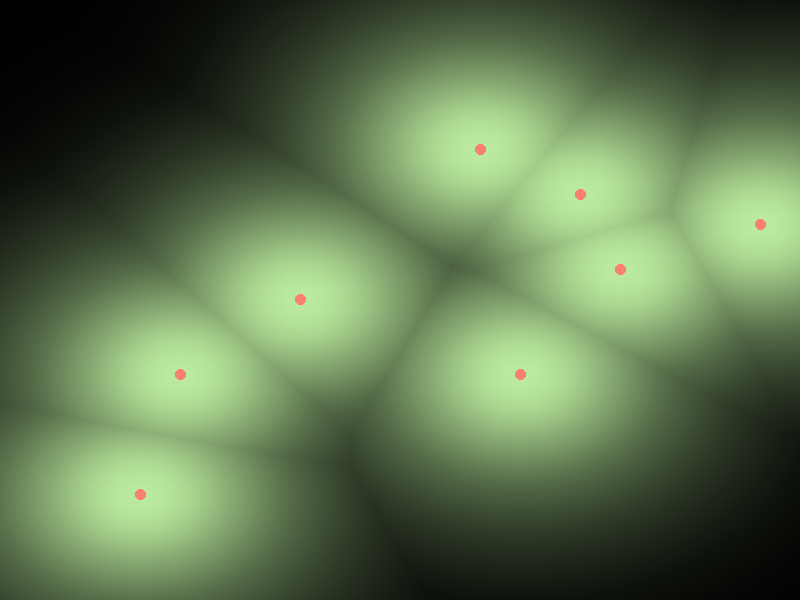

In [499]:
proximity_agg = proximity(points_agg, distance_metric="GREAT_CIRCLE")

stack(shade(proximity_agg, cmap=['#bbeb9e', 'black'], how='eq_hist'),
      points_shaded)

#### Apply proximity to a line:
Proximity is not restricted to points; it can be applied to aggregates of lines as well.

##### Setup:
We'll start by aggregating the points DataFrame from above, once again with the Canvas object,  
but with the canvas line method this time. 
We can also quickly shade and visualize it. 

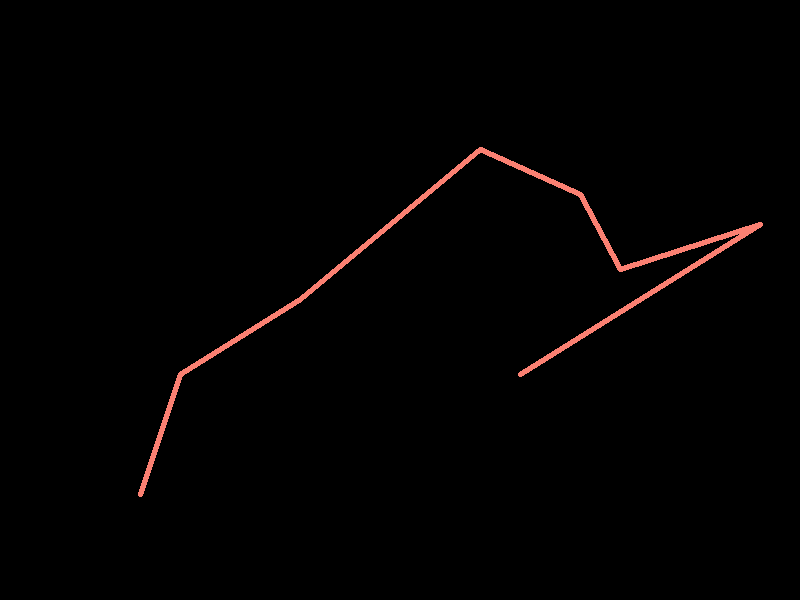

In [500]:
line_agg = cvs.line(df, x='x', y='y')
line_shaded = dynspread(shade(line_agg, cmap=['salmon',  'salmon']),
                          threshold=1,
                          max_px=2)
set_background(line_shaded, 'black')

##### Apply directly:
Now we can apply proximity to this aggregate directly and it gives us the smallest distance from any point on the line.

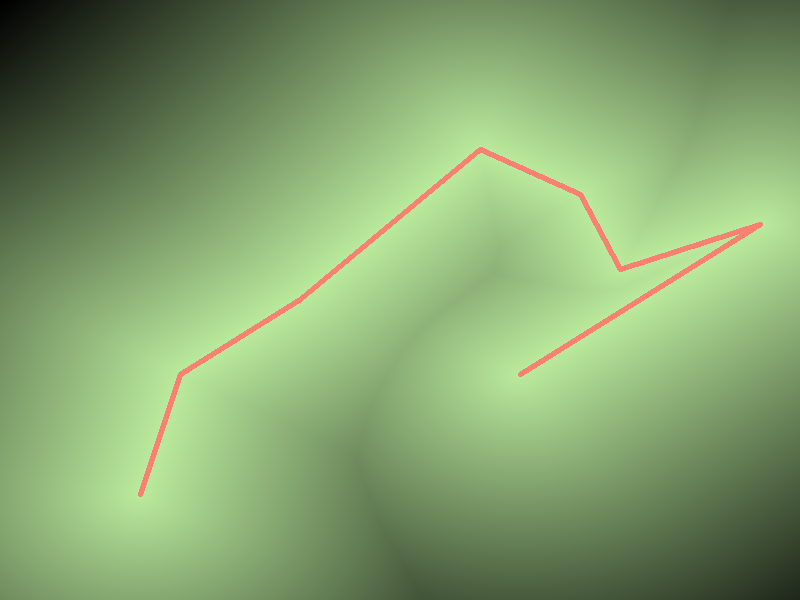

In [502]:
line_proximity = proximity(line_agg)
stack(shade(line_proximity, cmap=['#bbeb9e', 'black'], how='linear'),
      line_shaded)

##### Apply Proximity, then Transform:
Alternatively, since Xarray-spatial integrates so well with Xarray and Numpy, and the proximity return is in xarray.DataArray format, we can apply some functions from the DataArray API to display it more selectively.

Below is an example of using `DataArray.where()` to apply a minimum distance and maximum distance from the line points.
We'll apply this filter, then shade it and stack it with the original line raster.

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


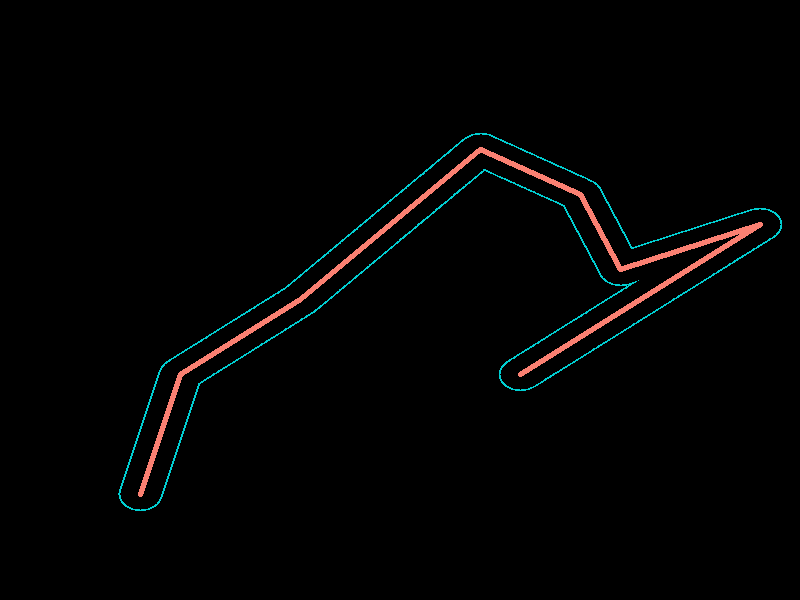

In [503]:
where_clause = (line_proximity > 1) & (line_proximity < 1.1)
line_proximity_one_to_one_point_one = line_proximity.where(where_clause)
proximity_shaded = shade(line_proximity_one_to_one_point_one, cmap=['darkturquoise', 'darkturquoise'])
proximity_shaded = set_background(proximity_shaded, 'black')
stack(proximity_shaded, line_shaded)

## Proximity Allocation

Similar to `xrspatial.proximity`, the `xrspatial.allocation` function operates on a given aggregate to produce the nearest source (instead of distance to nearest source) based on target values and a distance metric. The values in the new aggregate will be the value of the nearest feature.

In the same way, you can target specific values with the `target_values` parameter.

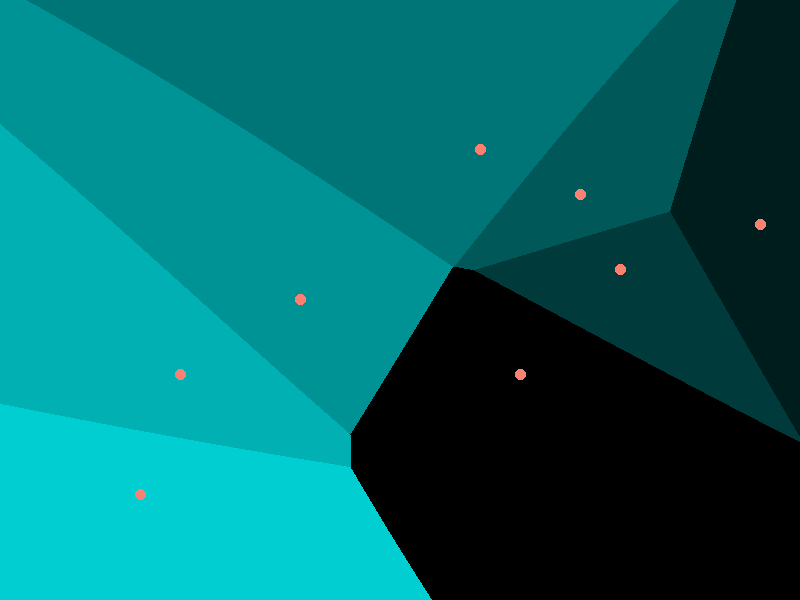

In [489]:
from xrspatial import allocation

allocation_agg = allocation(points_agg, distance_metric="GREAT_CIRCLE")
                            
stack(shade(allocation_agg, cmap=['darkturquoise', 'black'], how='linear'),
      points_shaded)

## Proximity Direction

Similar to `xrspatial.proximity`, the `xrspatial.direction` function operates on a given aggregate. It calculates for each pixel the direction to nearest source (instead of distance) based on target values and a distance metric. The output values are based on compass directions, range from 0 to 360:
- 0 is for the source cell itself
- 90 is the east
- 180 is the south
- 270 is the west
- 360 is the north

In the same way, you can target specific values with the `target_values` parameter.

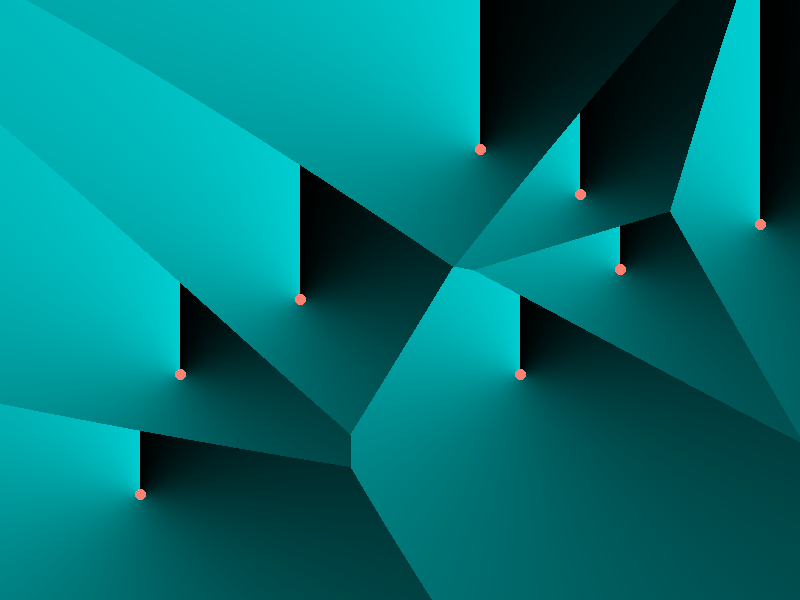

In [490]:
from xrspatial import direction

direction_agg = direction(points_agg, distance_metric="GREAT_CIRCLE")
                            
stack(shade(direction_agg, cmap=['darkturquoise', 'black'], how='linear'),
      points_shaded)




### References
An overview of the Distance toolset: https://pro.arcgis.com/en/pro-app/tool-reference/spatial-analyst/an-overview-of-the-distance-tools.htm